# SEL634 - Laboratório de Robôs Manipuladores

## Inicialização da biblioteca

Carregar a biblioteca de robótica para Python:

In [1]:
#!python3 -m pip install --user --upgrade pip==20.1
!pip install roboticstoolbox-python
!pip install spatialmath-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
#import roboticstoolbox as rtb
from roboticstoolbox import *
from spatialmath import *
from spatialmath.base import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# no Binder utilizar essa linha
# %matplotlib notebook  
# no Colab utilizar essa linha
%matplotlib inline

## Cinemática Direta do Robô Kinova Gen3

O robô Kinova Gen3 pode ser modelado pela seguinte função (ver Tarefa 2):

In [3]:
def kinova_robot(my_name):
  robot = DHRobot(
      [
       # Colocar seu código aqui para completar a descrição do robô
        RevoluteDH(d=-(0.1564+0.1284), alpha=pi/2),
            RevoluteDH(d=-(0.0054+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2104+0.2104), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.0064+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2084+0.1059), alpha=pi/2, offset=pi),
            RevoluteDH(alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.1059+0.0615), alpha=pi, offset=pi)
       ], name=my_name)
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  robot.base = H_B0
  return robot


A pose do efetuador do robô Kinova Gen3 é dada em relação a base, $B$, pela função:

In [4]:
def pose_efetuador(robot, q):
  H_B7 = robot.fkine(q)
  return H_B7

A biblioteca de robótica permite acessar as **matrizes de transformação homogênea intermediárias do modelo de cinemática direta do robô** (veja [documentação](https://petercorke.github.io/robotics-toolbox-python/arm_dh.html#roboticstoolbox.robot.DHRobot.DHRobot.A)) 

**É importante notar** que a transformação fixa $^BH_0$ é ignorada para este comando. 

Por exemplo, seja a variável `robot` o modelo retornado pela função `kinova_robot` criada anteriormente. O comando:

```
H = robot.A([j1,j2],q)
```

retorna a matriz de transformação homogênea `H` da junta `j2` em relação a junta `j1` para a configuração do robô `q`. 



Para obter a matriz de transformação homogênea $^0H_1$ para uma configuração `q` fornecida:
```
H = robot.A([0,0],q)
```

OBS: Aparentemente, a versão da biblioteca está considerando que quando se usa `j2=0` está se referindo ao sistema de coordenadas 1. Mas `j1=0` significa o sistema de coordenadas 0.

Para obter a matriz de transformação homogênea $^1H_2$ para uma configuração `q` fornecida:
```
H = robot.A([1,1],q)
```

Quando o sistema de referência é $0$, outra opção é usar o comando:
```
H = robot.A(j2,q)
```
Portanto, para recuperar $^0H_2$ para uma configuração `q` fornecida:
```
H = robot.A(1,q)
```
OBS: Aparentemente, a versão da biblioteca está considerando que quando se usa `j2=1` está se referindo ao sistema de coordenadas 2. 


A biblioteca de robótica possui uma função que retorna o **jacobiano do manipulador** para uma configuração `q` (em relação à base B):
```
J = robot.jacob0(q)
```
O comando acima retorna o Jacobiano completo $6 \times N$. 

Para obter apenas a parte superior do Jacobiano, que está relacionado a velocidade linear:
```
J = robot.jacob0(q,half='trans')
```
Para obter apenas a parte inferior do Jacobiano, que está relacionado a velocidade angular:
```
J = robot.jacob0(q,half='rot')
```

In [5]:
robot = kinova_robot("meu_robo")
q = np.array([0,0,0,0,0,0,0])
print("^0H_1 = \n",robot.A([0,0],q)) # matriz ^0H_1
print("^1H_2 = \n",robot.A([1,1],q)) # matriz ^1H_2
print("^0H_1 = \n",robot.A(0,q)) # matriz ^0H_1
print("^0H_2 = \n",robot.A(1,q)) # matriz ^0H_2
print("J = \n",robot.jacob0(q)) # Jacobiano 6xN (para o robô Kinova Gen3, N = 7) considerando q = [0 0 0 0 0 0 0]
print("Jv = \n",robot.jacob0(q,half='trans')) # Jv, parte superior de J (associado à velocidade linear v)
print("Jw = \n",robot.jacob0(q,half='rot')) # Jw, parte inferior de J (associado à velocidade angular w)

print("Jacobiano datatype: ",type(robot.jacob0(q)))

^0H_1 = 
    1         0         0         0         
   0         0        -1         0         
   0         1         0        -0.2848    
   0         0         0         1         

^1H_2 = 
   -1         0         0         0         
   0         0         1         0         
   0         1         0        -0.0118    
   0         0         0         1         

^0H_1 = 
    1         0         0         0         
   0         0        -1         0         
   0         1         0        -0.2848    
   0         0         0         1         

^0H_2 = 
   -1         0         0         0         
   0        -1         0         0.0118    
   0         0         1        -0.2848    
   0         0         0         1         

J = 
 [[ -0.0246   0.9025  -0.0128   0.4817        0   0.1674        0]
 [       0        0        0        0        0        0        0]
 [       0        0        0        0        0        0        0]
 [       0        0        0        0        0  

## Trajetória do Robô no Espaço das Juntas

Considere que a junta $i$ possui a seguinte trajetória  em graus no tempo que leva a junta $i$ da posição $\theta_{si}$ até $\theta_{gi}$ em um dado tempo $T_d$:
$$ \theta_i (t) = c_{0i} + c_{1i} t + c_{2i} t^2 + c_{3i} t^3 + c_{4i} t^4 + c_{5i} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo:
\begin{eqnarray*}
	&c_{0i}& = \theta_{si}\\
	&c_{1i}& = c_{2i} = 0\\
	&c_{3i}& = \frac{10(\theta_{gi}-\theta_{si})}{T_d^{3}}\\
	&c_{4i}& = \frac{15(\theta_{si}-\theta_{gi})}{T_d^{4}}\\
	&c_{5i}& = \frac{6(\theta_{gi}-\theta_{si})}{T_d^{5}}
\end{eqnarray*}

A velocidade de cada junta para condições iniciais nulas é dada por:
$$ \dot\theta_i (t) = c_{1i} + 2c_{2i} t + 3c_{3i} t^2 + 4c_{4i} t^3 + 5c_{5i} t^4 $$

A aceleração de cada junta para condições iniciais nulas é dada por:
$$ \ddot\theta_i (t) = 2c_{2i} + 6c_{3i} t + 12c_{4i} t^2 + 20c_{5i} t^3 $$

A função a seguir foi implementada na Tarefa 3 para calcular a trajetória das juntas do manipulador:


In [6]:
def calcular_trajetoria(theta_s, theta_g, Td, dt):
  # Coloque seu codigo aqui
    N = theta_s.size # Array length
    
    c0 = theta_s
    c1 = np.zeros(N)
    c2 = c1
    c3 = 10*(theta_g-theta_s)/Td**3
    c4 = 15*(theta_s-theta_g)/Td**4
    c5 = 6*(theta_g-theta_s)/Td**5
    
    #print(c1)

    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    t2 = np.power(t,2)
    t3 = np.power(t,3)
    t4 = np.power(t,4)
    t5 = np.power(t,5)
    
    M = len(t) # Number of points used in the trajectory discretization
    #print(c3)

    #here adjust MxN dimensions 
    # https://numpy.org/doc/stable/user/basics.broadcasting.html
    # https://numpy.org/doc/stable/reference/generated/numpy.tile.html?highlight=numpy%20tile#numpy.tile
    
    tVec = np.transpose(np.tile(t,(N,1)))
    tVec2 = np.transpose(np.tile(t2,(N,1)))
    tVec3 = np.transpose(np.tile(t3,(N,1)))
    tVec4 = np.transpose(np.tile(t4,(N,1)))
    tVec5 = np.transpose(np.tile(t5,(N,1)))
    
    onesVec = np.ones((M,N))
    
    #print(tVec2)
    #print("M =",M)
    #print(tVec*c1[np.newaxis,:])
    
    theta_t = onesVec*c0[np.newaxis,:] + tVec*c1[np.newaxis,:] + tVec2*c2[np.newaxis,:] + tVec3*c3[np.newaxis,:] + tVec4*c4[np.newaxis,:] + tVec5*c5[np.newaxis,:]
    dtheta_t = onesVec*c1[np.newaxis,:] + 2*tVec*c2[np.newaxis,:] + 3*tVec2*c3[np.newaxis,:] + 4*tVec3*c4[np.newaxis,:] + 5*tVec4*c5[np.newaxis,:]
    ddtheta_t = 2*onesVec*c2[np.newaxis,:] + 2*3*tVec*c3[np.newaxis,:] + 3*4*tVec2*c4[np.newaxis,:]+4*5*tVec3*c5[np.newaxis,:]
    return theta_t, dtheta_t, ddtheta_t

# Testing the function
# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 1
# dt = 0.1
# [theta1, theta2, theta3] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# print(theta1)

# Multi-line edit: https://stackoverflow.com/questions/60053748/google-colab-edit-two-lines-at-the-same-time

A função a seguir foi implementada na Tarefa 3 para calcular a sequencia no tempo de matrizes de transformação homogênea que representa a pose do robô (posição e orientação do efetuador)

In [7]:
def calcular_traj_efetuador(robot, theta_t):
  # Coloque seu codigo aqui
  # print("theta_t = ",theta_t[:,0]) # Testr
  HH = pose_efetuador(robot,theta_t)
  HHnp = np.array(HH[:].A) # Conversão para np.array
  HH_efetuador = HHnp
  return HH_efetuador

# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 1
# dt = 0.1
# [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# robot1 = kinova_robot("KinovaGen3_P1")
# HH = calcular_traj_efetuador(robot1,theta_t)

# print(HH)

## 4. Velocidade do Efetuador do Robô Manipulador

Na tarefa 4, você vai implementar funções para calcular a velocidade do efetuador do manipulador Kinova Gen3 em relação a sua base $B$.

### 4.1 Jacobiano do Manipulador

Implemente uma função semelhante àquela disponível na biblioteca de robótica para calcular o Jacobiano do manipulador em relação ao sistema de coordenada $\{0\}$. Nesta etapa não considere a transformação homogênea $^BH_0$. 

**Entrada:** modelo cinemático do robô, e o vetor de configuração do robô em um determinado instante de tempo ($6 \times 1$).

**Saída:** o Jacobinado do efetuador em relação ao sistema de coordenadas $\{0\}$ para um instante de tempo, ou seja, matriz $6 \times N$.


In [8]:
def calcular_jacobiano(robot,theta):
  # Nosso objetivo é chegar na seguinte matriz:
  # Jref = robot.jacob0(theta)
  # print("Jref = \n",Jref) # Jacobiano 6xN 
  # print("\n")

  # Coloque seu codigo aqui
  N = theta.shape[0]
  d = list() # Dica do Vinícius
  R = list()

  d.append(np.array([0,0,0])) # ^0d_0
  R.append(np.identity(3)) # ^0R_0

  for i in range(N):
    Hi = robot.A(i,theta)
    # print("H"+str(i)+"= \n",Hi,"\n")
    R.append(Hi.R) # R.append(SO3(robot.A(i,theta)))
    d.append(Hi.t)

  # print(type(Hi)) # <class 'spatialmath.pose3d.SE3'>
  # H02 = robot.A(1,theta) # matriz ^0H_2

  # print(R[0])
  # print("z = \n", R[0][:,2])
  # print(skew(R[0][:,2]))

  # Testes: i = 0 até N-1
  # i = N-1
  # zi = R[i][:,2]
  # xProd = np.dot(skew(zi),(d[N-1]-d[i]))
  # print(zi)
  # print("Skew zi = \n",skew(zi))
  # print("Vec = \n",d[N-1]-d[i])
  # print("xProd = \n",xProd)

  # O robô Kinova Gen3 possui apenas matrizes de rotação.

  # Submatrizes Jv (velocidade linear)
  Jv = list()
  for i in range(N):
    zi = R[i][:,2]
    xProd = np.dot(skew(zi),(d[N]-d[i])) # J_{vi} = ^0z_{i−1} × ^0o_n − ^0o_{i−1}, d[N] = d[7], que corresponde às coordenadas do efetuador em relação a {0}.
    Jv.append(xProd)
  
  # print(d[6])
  # print(type(Jv[0]))

  # Submatrizes Jw (velocidade angular)
  Jw = list()
  for i in range(N):
    Jw.append(R[i][:,2])

  J_efetuador = np.zeros((6,N)) # Matriz de 0s de dimensão 6xN

  # print(Jref[:,0])
  # print(Jv[5])
  # print(Jw[0])
  # J_efetuador[0:3,0] = np.array([1,2,3])
  # J_efetuador[3:6,0] = np.array([4,5,6])
  # print(J_efetuador)
  # print(J_efetuador[0:3,0])
  # print(J_efetuador[3:6,0])

  # Montando a matriz Jacobiana

  for i in range(N):
    J_efetuador[0:3,i] = Jv[i]
    J_efetuador[3:6,i] = Jw[i]

  return J_efetuador

# Teste da função
# theta_s = np.array([0,1,2,3,4,5,6])
# robot1 = kinova_robot("KinovaGen3_P1")
# Jteste = calcular_jacobiano(robot1,theta_s)
# print("test\n")
# print("J = \n",Jteste)

### 4.2 Velocidade do Manipulador

Implemente uma função que calcula a velocidade do efetuador do Kinova Gen3 em relação a base. Para isso utilize a função implementada no item 4.1.

O calculo das velocidades linear e angular do manipulador em relação ao sistema $\{0\}$ para um dado instante de tempo é:

$$\begin{bmatrix} ^0v_n(t) \\ ^0w_n(t) \end{bmatrix} = {^0J_n}(q(t)) ~\dot q(t) $$

Como a origem do sistema de coordenadas $\{0\}$ e $\{B\}$ coincidem, para transformar o vetor de velocidades para o sistema de coordenadas da base $\{B\}$:

$$ \begin{bmatrix} ^Bv_n(t) \\ ^Bw_n(t) \end{bmatrix} = {^BR_0}\begin{bmatrix} ^0v_n(t) \\ ^0w_n(t) \end{bmatrix} $$

**Entrada:** modelo cinemático do robô, vetor de configuração do robô no tempo ($N \times M$), velocidade das juntas do robô no tempo ($N \times M$), onde $M$ é a quantidade de pontos da trajetória no tempo (ver Tarefa 3).

**Saída:** Velocidade linear (m/s) e angular (rad/s) do efetuador em relação ao sistema de coordenadas $\{B\}$ ao longo do tempo (matriz $6 \times M$) 

In [9]:
def calcular_vel_efetuador(robot,theta_t,dtheta_t):
  # Coloque seu codigo aqui
  H_B0 = robot.base
  # print(H_B0)
  M = theta_t.shape[0]

  v_efetuador = np.zeros((3,M))
  w_efetuador = np.zeros((3,M)) # Inicialização das matrizes de saída
  # Atenção: não usar w_efetuador = v_efetuador! Por algum motivo, isso gera distorções quando os valores de interesse são atribuídos.
  # V_efetuador = np.vstack((v_efetuador,w_efetuador))
  # print(V_efetuador.shape)

  # Jteste = calcular_jacobiano(robot,theta_t[0])
  # J_B0v = np.dot(H_B0.R,Jteste[0:3,:])
  # J_B0w = np.dot(H_B0.R,Jteste[3:6,:])
  # print("J_B0v = \n",J_B0v)
  # print("J_B0w = \n",J_B0w)
  # lin_velv = np.dot(J_B0v,dtheta_t[0])
  # ang_velw = np.dot(J_B0w,dtheta_t[0])
  # print("lin_velv = \n",lin_velv)
  # print("ang_velw = \n",ang_velw)

  print("Problema aqui! Matrizes diferentes. Não sei porquê.")
  for i in range(M):
    Jac = calcular_jacobiano(robot,theta_t[i])
    J_B0v = np.dot(H_B0.R,Jac[0:3,:]) # Obtendo J das velocidades lineares, Jv, em relação à base B
    v_efetuador[:,i] = np.dot(J_B0v,dtheta_t[i])
    J_B0w = np.dot(H_B0.R,Jac[3:6,:]) # Obtendo J das velocidades angulares, Jw, em relação à base B
    w_efetuador[:,i] = np.dot(J_B0w,dtheta_t[i])
    
    # print("\n",np.dot(J_B0v,dtheta_t[i]))
    # print(v_efetuador[:,i],"\n")    
    # print("\n",np.dot(J_B0w,dtheta_t[i]))
    # print(w_efetuador[:,i],"\n")


  V_efetuador = np.vstack((v_efetuador,w_efetuador))
  return V_efetuador

# Testing the function
theta_s = np.array([0,1,2,3,4,5,6])
theta_g = np.array([1,2,3,4,5,6,7])
Td = 0.9
dt = 0.1
[theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
robot1 = kinova_robot("KinovaGen3_P1")
V_efetuador = calcular_vel_efetuador(robot1,theta_t,dtheta_t)
# print(V_efetuador)

# Autocomplete suggestions in Colab: https://stackoverflow.com/questions/52438415/is-it-possible-to-have-autocomplete-in-a-notebook-in-google-colab

Problema aqui! Matrizes diferentes. Não sei porquê.


### 4.3 Velocidade do Manipulador - Calculo alternativo

Implemente a mesma função anterior, mas utilizando o calculo de Jacobiano feito pela biblioteca de robótica através da função [`jacob0`](https://petercorke.github.io/robotics-toolbox-python/arm_dh.html#roboticstoolbox.robot.DHRobot.DHRobot.jacob0): 

`J = robot.jacob0(q)`



Possivelmente, da mesma forma como feito no item 4.2, será necessário calcular a as velocidades em relação ao sistema $\{0\}$, e então converter para o sistema $\{B\}$ utilizando a matriz de rotação ${^BR_0}$. 

---> Na realidade não, jacob0 já fornece J em relação à base B (se presente na definição do robô)

In [10]:
def calcular_vel_efetuador_alternativo(robot,theta_t,dtheta_t):
  # Coloque seu codigo aqui
  M = theta_t.shape[0]
  V_efetuador = np.zeros((6,M))

  for i in range(M):
    Jac = robot.jacob0(theta_t[i])
    V_efetuador[:,i] = np.dot(Jac,dtheta_t[i])

  return V_efetuador

# Testing the function
# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 0.9
# dt = 0.1
# [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# robot1 = kinova_robot("KinovaGen3_P1")
# V_efetuador = calcular_vel_efetuador(robot1,theta_t,dtheta_t)
# print(V_efetuador)

### 4.4 Plotar velocidade do efetuador

Implemente uma função para gerar dois gráficos: um gráfico para mostrar a evolução no tempo de cada componente da velocidade linear; outro gráfico para mostrar no tempo a evoluçào da velocidade angular. Utilize as funções implementadas no item 4.1 e 4.2.


In [11]:
def plotar_vel_efetuador(robot, theta_t, dtheta_t, Td, dt):
  # Coloque seu codigo aqui

    # Criar vetor tempo
    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    M = t.shape[0]

    # Obter curvas theta
    [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
    V_efetuador = calcular_vel_efetuador(robot1,theta_t,dtheta_t)
    v_efetuador = V_efetuador[0:3,:]
    w_efetuador = V_efetuador[3:6,:]

    N = theta_t.shape[1]
    lgn_v = ["$v_x$","$v_t$","$v_z$"]
    lgn_w = ["$\omega_x$","$\omega_t$","$\omega_z$"]

    # Construir os gráficos
    fig = plt.figure()
    fig.suptitle('Velocidade do efetuador',fontsize = 16)
    ax1 = fig.add_subplot(1,1,1)
    for i in range(3):
      ax1.plot(t,v_efetuador[i,:])
    ax1.grid(True)
    # ax1.legend(lgn,loc = "upper left",ncol=len(lgn))
    ax1.legend(lgn_v,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Velocidade linear $v$ [m/s]')
    # https://matplotlib.org/3.5.0/tutorials/text/mathtext.html

    fig = plt.figure() 
    ax2 = fig.add_subplot(1,1,1)
    for i in range(3):
      ax2.plot(t,w_efetuador[i,:])
    ax2.grid(True)
    ax2.legend(lgn_w,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Velocidade angular $\omega$ [rad/s]')

# Testing the function
# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 0.9
# dt = 0.1
# [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# robot1 = kinova_robot("KinovaGen3_P1")
# plotar_vel_efetuador(robot, theta_t, dtheta_t, Td, dt)

Faça outra função para gerar os mesmos gráficos de velocidade, mas utilizando a função implementada no item 4.3.

In [12]:
def plotar_vel_efetuador_alternativo(robot, theta_t, dtheta_t, Td, dt):
  # Coloque seu codigo aqui
    
    # Criar vetor tempo
    start = 0
    step = dt
    end = Td+step
    t = np.arange(start,end,step)
    M = t.shape[0]

    # Obter curvas theta
    [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
    V_efetuador = calcular_vel_efetuador_alternativo(robot1,theta_t,dtheta_t)
    v_efetuador = V_efetuador[0:3,:]
    w_efetuador = V_efetuador[3:6,:]

    N = theta_t.shape[1]
    lgn_v = ["$v_x$","$v_t$","$v_z$"]
    lgn_w = ["$\omega_x$","$\omega_t$","$\omega_z$"]

    # Construir os gráficos
    fig = plt.figure()
    fig.suptitle('Velocidade (alternativa) do efetuador',fontsize = 16)
    ax1 = fig.add_subplot(1,1,1)
    for i in range(3):
      ax1.plot(t,v_efetuador[i,:])
    ax1.grid(True)
    # ax1.legend(lgn,loc = "upper left",ncol=len(lgn))
    ax1.legend(lgn_v,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Velocidade linear alt. $v$ [m/s]')
    # https://matplotlib.org/3.5.0/tutorials/text/mathtext.html

    fig = plt.figure() 
    ax2 = fig.add_subplot(1,1,1)
    for i in range(3):
      ax2.plot(t,w_efetuador[i,:])
    ax2.grid(True)
    ax2.legend(lgn_w,loc = "upper right")
    plt.xlabel('Tempo (s)')
    plt.ylabel(r'Velocidade angular alt. $\omega$ [rad/s]')

# Testing the function
# theta_s = np.array([0,1,2,3,4,5,6])
# theta_g = np.array([1,2,3,4,5,6,7])
# Td = 0.9
# dt = 0.1
# [theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
# robot1 = kinova_robot("KinovaGen3_P1")
# plotar_vel_efetuador_alternativo(robot, theta_t, dtheta_t, Td, dt)

Os gráficos gerados devem ser iguais. 

### 4.5 Teste das funções

Faça o teste das funções do item 4.4 para os seguintes parâmetros: $T_d = 10$ segundos, $\delta t = 0.01$ segundos,  posição inicial das juntas $\theta_s = [0, 0, 0, 0, 0, 0, 0]^T$  e posição final das juntas $\theta_g = [90, 90, 0, -90, 0, 90, 0]^T$ dada em graus.

Problema aqui! Matrizes diferentes. Não sei porquê.


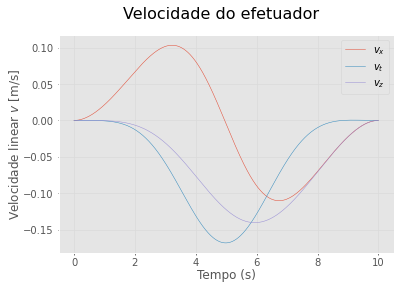

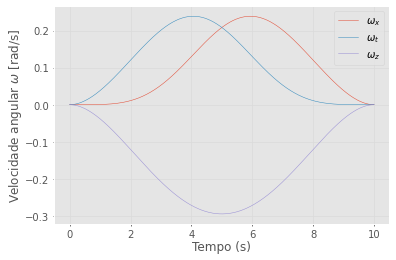

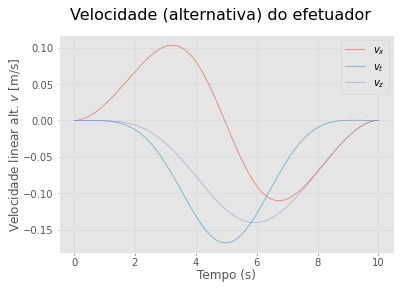

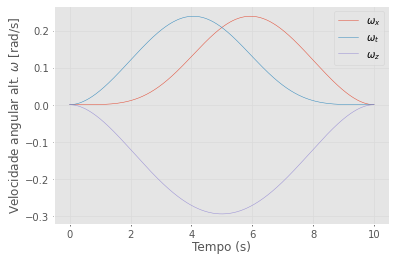

In [13]:
Td = 10.0
dt = 0.01
theta_s = np.array([0,0,0,0,0,0,0])*pi/180
theta_g = np.array([90,90,0,-90,0,90,0])*pi/180

[theta_t, dtheta_t, ddtheta_t] = calcular_trajetoria(theta_s,theta_g,Td,dt)
robot1 = kinova_robot("KinovaGen3_P1")
plotar_vel_efetuador(robot, theta_t, dtheta_t, Td, dt)
plotar_vel_efetuador_alternativo(robot, theta_t, dtheta_t, Td, dt)


## Dicas do Professor para a atividade 5
Quando o sistema de coordenadas da base possui origem coincidente com o sistema \{0\}, tem-se:

$$^BH_0 = \begin{bmatrix} ^BR_0 & 0 \\ 0 & 1 \end{bmatrix} $$